<a href="https://colab.research.google.com/github/vkthakur90/AI_Applications/blob/master/Joint_ARMA(1%2C1)_%2B_GARCH(1%2C1)_in_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install (if needed) and load required packages
#if (!require("quantmod")) install.packages("quantmod", dependencies=TRUE)
#if (!require("rugarch")) install.packages("rugarch", dependencies=TRUE)
#if (!require("ggplot2")) install.packages("ggplot2", dependencies=TRUE)

In [2]:
library(quantmod)
library(rugarch)
library(ggplot2)

Loading required package: xts

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: TTR

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Loading required package: parallel


Attaching package: ‘rugarch’


The following object is masked from ‘package:stats’:

    sigma




In [3]:
#-----------------------------
# 1. Download stock data from Yahoo Finance (Example: AAPL)
# Set date range for the past 5 years
end_date <- Sys.Date()
start_date <- as.character(end_date - 5*365)  # approximate 5 years ago
getSymbols("AAPL", src = "yahoo", from = start_date, to = end_date)

# Use Adjusted Close prices
prices <- Ad(AAPL)


[1] "AAPL"

In [4]:
#-----------------------------
# 2. Compute daily logarithmic returns in percentage
log_returns <- 100 * diff(log(prices))
log_returns <- na.omit(log_returns)

In [5]:
#-----------------------------
# 3. Split data into train and test sets (80% train, 20% test)
n_total <- length(log_returns)
train_size <- floor(0.8 * n_total)
train_returns <- log_returns[1:train_size]
test_returns  <- log_returns[(train_size + 1):n_total]

# For the train-forecast, the starting price is the price corresponding to the end of the training period.
# Because diff(log(prices)) produces one less observation, the last training return corresponds to prices[train_size+1].
last_train_price <- as.numeric(prices[train_size + 1])

# Actual test prices for plotting (adjust indices accordingly)
# Test returns start at time train_size+1, so actual test prices start at prices[train_size+2]
actual_test_prices <- prices[(train_size + 2):length(prices)]
test_dates <- index(actual_test_prices)

In [6]:
# 4. Fit ARMA(1,1)+GARCH(1,1) on Train Data and Forecast Test Period
spec <- ugarchspec(
  variance.model = list(model = "sGARCH", garchOrder = c(1, 1)),
  mean.model     = list(armaOrder = c(1, 1), include.mean = TRUE),
  distribution.model = "norm"
)

# Fit on training returns
fit_train <- ugarchfit(spec = spec, data = train_returns)

# Forecast horizon equals length of test returns
h_test <- length(test_returns)

# Monte Carlo simulation for test forecast using 500 simulation paths
sim_train <- ugarchsim(fit_train, n.sim = h_test, n.start = 0, m.sim = 500)
sim_train_matrix <- fitted(sim_train)  # simulated returns (in %)

# Convert percentage returns to log returns and compute cumulative returns for each simulation
sim_train_log_returns <- sim_train_matrix / 100
sim_train_cum <- apply(sim_train_log_returns, 2, cumsum)
sim_train_prices <- last_train_price * exp(sim_train_cum)

# Compute forecast statistics for test period (price level)
price_test_mean  <- apply(sim_train_prices, 1, mean)
price_test_lower <- apply(sim_train_prices, 1, quantile, probs = 0.025)
price_test_upper <- apply(sim_train_prices, 1, quantile, probs = 0.975)

# Create a data frame for the test forecast with dates (using test_dates)
df_test_forecast <- data.frame(Date = test_dates,
                               Forecast = price_test_mean,
                               Lower = price_test_lower,
                               Upper = price_test_upper)
# Data frame for actual test prices
df_test_actual <- data.frame(Date = test_dates,
                             Price = as.numeric(actual_test_prices))

In [7]:
#-----------------------------
# 5a. Fit ARMA(1,1)+GARCH(1,1) on Whole Data and Forecast n Business Days Ahead
fit_full <- ugarchfit(spec = spec, data = log_returns)

# Set forecast horizon (n business days ahead)
n_future <- 100

sim_full <- ugarchsim(fit_full, n.sim = n_future, n.start = 0, m.sim = 500)
sim_full_matrix <- fitted(sim_full)

sim_full_log_returns <- sim_full_matrix / 100
sim_full_cum <- apply(sim_full_log_returns, 2, cumsum)
last_price <- as.numeric(prices[length(prices)])
sim_full_prices <- last_price * exp(sim_full_cum)

price_future_mean  <- apply(sim_full_prices, 1, mean)
price_future_lower <- apply(sim_full_prices, 1, quantile, probs = 0.025)
price_future_upper <- apply(sim_full_prices, 1, quantile, probs = 0.975)

# Generate forecast dates for future business days (skipping weekends)
last_date <- as.Date(index(prices)[length(prices)])
potential_dates <- seq(from = last_date + 1, by = "day", length.out = n_future * 2)
future_dates <- potential_dates[!weekdays(potential_dates) %in% c("Saturday", "Sunday")][1:n_future]

df_future_forecast <- data.frame(Date = future_dates,
                                 Forecast = price_future_mean,
                                 Lower = price_future_lower,
                                 Upper = price_future_upper)

In [8]:
#----------------------------------
# 5b. Prepare Historical Data for the Plot: Use the Last 100 Days Only
price_dates <- as.Date(index(prices))
n_prices <- length(prices)
df_hist_100 <- data.frame(Date = price_dates[(n_prices - 99):n_prices],
                          Price = as.numeric(prices[(n_prices - 99):n_prices]))

In [9]:
#-----------------------------
# 6. Prepare Historical Price Data for Plotting
df_prices <- data.frame(Date = as.Date(index(prices)),
                        Price = as.numeric(prices))

In [11]:
#-----------------------------
# 7. Plot: Historical Prices, Train-Test Forecast, and Future Forecast
# Plot 1: Train-to-Test Forecast
p1 <- ggplot() +
  # Historical prices (all)
  geom_line(data = df_prices, aes(x = Date, y = Price), color = "black", size = 0.5) +
  # Forecast from Train Model on Test Period
  geom_ribbon(data = df_test_forecast, aes(x = Date, ymin = Lower, ymax = Upper),
              fill = "red", alpha = 0.2) +
  # Actual Test Prices
  geom_line(data = df_test_actual, aes(x = Date, y = Price), color = "blue", size = 0.7) +
  labs(title = "Train-to-Test Forecast",
       subtitle = "ARMA(1,1)+GARCH(1,1) model fitted on Train Data",
       x = "Date", y = "Price (Adjusted)") +
  theme_minimal()

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


In [16]:
# 6. Plot the Last 100 Days of History and the Future Forecast
p_future <- ggplot() +
  # Plot historical prices for the previous 100 days
  geom_line(data = df_hist_100, aes(x = Date, y = Price), color = "black", size = 0.5) +
  # Plot future forecast mean prices
  # Add 95% confidence interval
  geom_ribbon(data = df_future_forecast, aes(x = Date, ymin = Lower, ymax = Upper),
              fill = "green", alpha = 0.2) +
  labs(title = paste("Future Forecast for", n_future, "Business Days"),
       subtitle = "Showing the Previous 100 Days of History",
       x = "Date", y = "Price (Adjusted)") +
  theme_minimal() +
  # Add a vertical dashed line at the last observed date
  geom_vline(xintercept = last_date, linetype = "dashed", color = "gray")


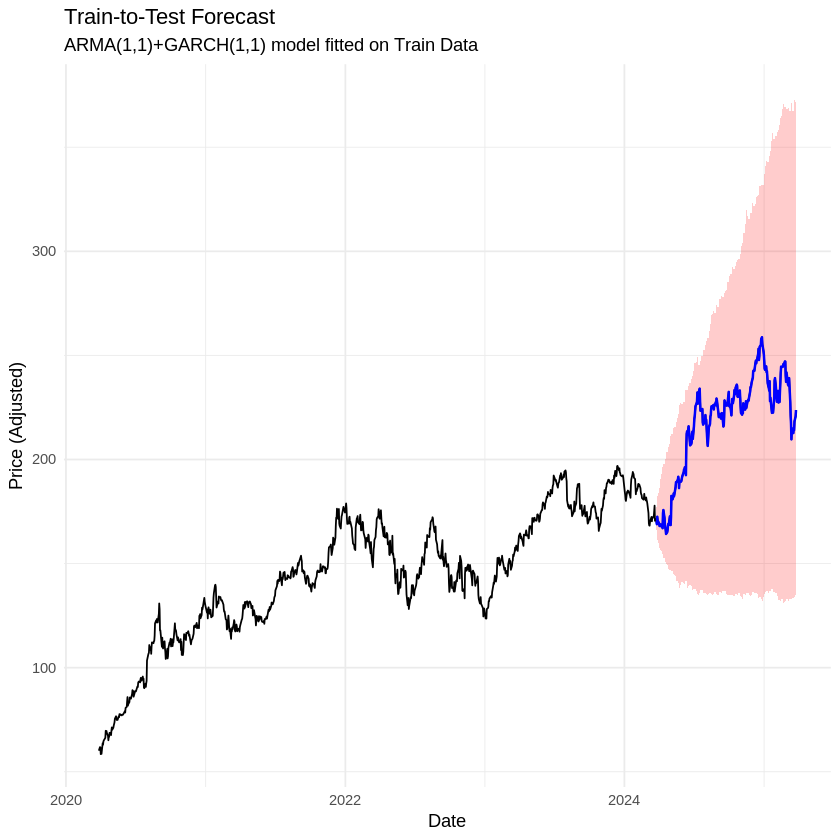

In [13]:
p1

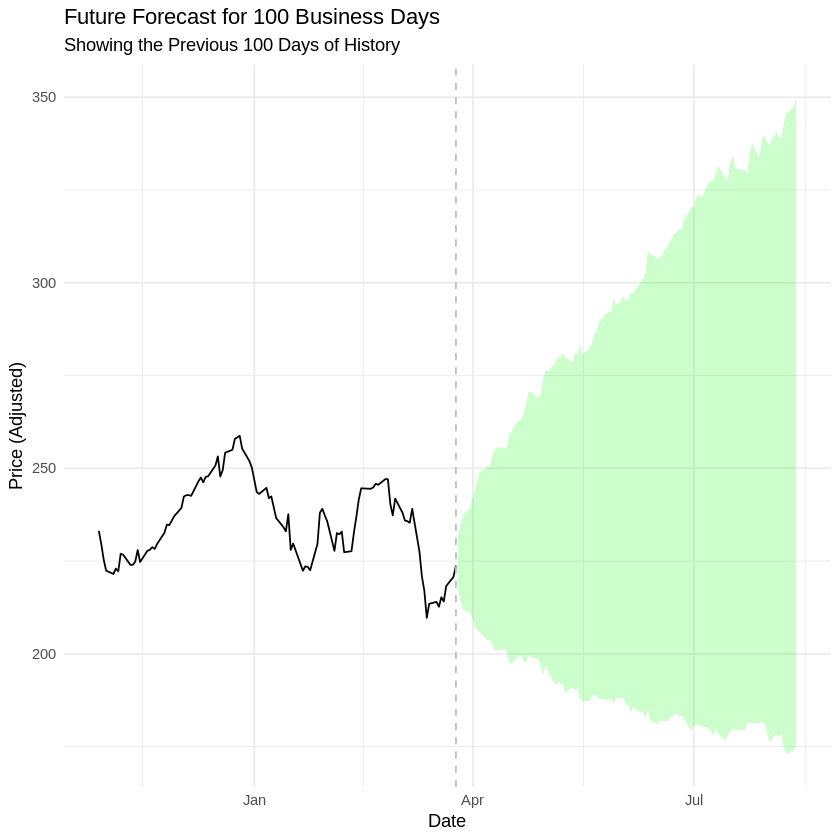

In [17]:
p_future